# 1. Environment and Dependencies Setup

In [1]:
# Install dependencies
!pip install -q ultralytics
!pip install -q supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import re
import yaml
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from tqdm import tqdm
import warnings
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.patches as patches
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Check GPU
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("⚠️ No GPU detected. Training will use CPU (slower).")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
CUDA version: 12.6


In [3]:
# Define Kaggle paths
COLOR_PATH = Path('/kaggle/input/oil-color-dataset')
DIPSTICK_PATH = Path('/kaggle/input/oil-dataset')
OUT_PATH = Path('/kaggle/working/')
MODEL_PATH = Path('/kaggle/input/model-yolov11-seg')

# Color Annotation files (filtered dataset with valid only images)
COLOR_ANNOT_PATH = COLOR_PATH / 'annot'
COLOR_ANNOT_TRAIN = COLOR_ANNOT_PATH / 'annotations_train_filtered.xml'
COLOR_ANNOT_VAL = COLOR_ANNOT_PATH / 'annotations_val_filtered.xml'
COLOR_ANNOT_TEST = COLOR_ANNOT_PATH / 'annotations_test_filtered.xml'

# Dipstick Annotation files (FULL oil-dataset - split by folder)
# Note: These are CVAT XML files in each split folder
DIPSTICK_ANNOT_TRAIN = DIPSTICK_PATH / 'train' / 'labels'
DIPSTICK_ANNOT_VAL = DIPSTICK_PATH / 'val' / 'labels'
DIPSTICK_ANNOT_TEST = DIPSTICK_PATH / 'test' / 'labels'

# Image directories (from COLOR dataset - filtered valid only)
TRAIN_IMG_PATH = COLOR_PATH / 'train' / 'images'
VAL_IMG_PATH = COLOR_PATH / 'val' / 'images'
TEST_IMG_PATH = COLOR_PATH / 'test' / 'images'

# Dipstick image directories (for reference)
DIPSTICK_TRAIN_IMG_PATH = DIPSTICK_PATH / 'train' / 'images'
DIPSTICK_VAL_IMG_PATH = DIPSTICK_PATH / 'val' / 'images'
DIPSTICK_TEST_IMG_PATH = DIPSTICK_PATH / 'test' / 'images'

# Output directories
YOLO_DATA_PATH = OUT_PATH / 'yolo_dataset'
MODEL_SAVE_PATH = OUT_PATH / 'models'

# Create output directories
YOLO_DATA_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)

print("📁 Paths Configuration:")
print(f"   Color Dataset Path: {COLOR_PATH}")
print(f"   Full Dipstick Dataset Path: {DIPSTICK_PATH}")
print(f"   Output Path: {OUT_PATH}")
print(f"   Annotations:")
print(f"     - Color Train: {COLOR_ANNOT_TRAIN}")
print(f"     - Color Val: {COLOR_ANNOT_VAL}")
print(f"     - Color Test: {COLOR_ANNOT_TEST}")
print(f"     - Full Dipstick Train XML: {DIPSTICK_ANNOT_TRAIN}")
print(f"     - Full Dipstick Val XML: {DIPSTICK_ANNOT_VAL}")
print(f"     - Full Dipstick Test XML: {DIPSTICK_ANNOT_TEST}")
print(f"   Images (from filtered color dataset):")
print(f"     - Train: {TRAIN_IMG_PATH}")
print(f"     - Val: {VAL_IMG_PATH}")
print(f"     - Test: {TEST_IMG_PATH}")

📁 Paths Configuration:
   Color Dataset Path: /kaggle/input/oil-color-dataset
   Full Dipstick Dataset Path: /kaggle/input/oil-dataset
   Output Path: /kaggle/working
   Annotations:
     - Color Train: /kaggle/input/oil-color-dataset/annot/annotations_train_filtered.xml
     - Color Val: /kaggle/input/oil-color-dataset/annot/annotations_val_filtered.xml
     - Color Test: /kaggle/input/oil-color-dataset/annot/annotations_test_filtered.xml
     - Full Dipstick Train XML: /kaggle/input/oil-dataset/train/labels
     - Full Dipstick Val XML: /kaggle/input/oil-dataset/val/labels
     - Full Dipstick Test XML: /kaggle/input/oil-dataset/test/labels
   Images (from filtered color dataset):
     - Train: /kaggle/input/oil-color-dataset/train/images
     - Val: /kaggle/input/oil-color-dataset/val/images
     - Test: /kaggle/input/oil-color-dataset/test/images


# 2. Parse and fetch annotations (Only valid min-max dipstick filter)

In [4]:
def parse_cvat_xml(xml_path, exclude_labels=None):
    """
    Parse CVAT XML annotation file.
    
    Returns dict with image_name as key and annotation data as value.
    """
    if exclude_labels is None:
        exclude_labels = []
    
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    annotations = {}
    
    for image in root.findall('.//image'):
        img_name = image.get('name')
        img_width = int(image.get('width'))
        img_height = int(image.get('height'))
        
        img_annotations = {
            'image_name': img_name,
            'width': img_width,
            'height': img_height,
            'labels': []
        }
        
        # Parse polygons
        for polygon in image.findall('polygon'):
            label = polygon.get('label')
            
            # Skip excluded labels
            if label in exclude_labels:
                continue
                
            points_str = polygon.get('points')
            
            # Get color attribute if exists
            color_attr = polygon.find(".//attribute[@name='color']")
            color = color_attr.text if color_attr is not None else None
            
            # Parse points
            points = []
            if points_str:
                for pt in points_str.split(';'):
                    x, y = map(float, pt.split(','))
                    points.append((x, y))
            
            img_annotations['labels'].append({
                'type': 'polygon',
                'label': label,
                'color': color,
                'points': points
            })
        
        # Parse polylines (Min Mark)
        for polyline in image.findall('polyline'):
            label = polyline.get('label')
            
            # Skip excluded labels
            if label in exclude_labels:
                continue
                
            points_str = polyline.get('points')
            
            points = []
            if points_str:
                for pt in points_str.split(';'):
                    x, y = map(float, pt.split(','))
                    points.append((x, y))
            
            img_annotations['labels'].append({
                'type': 'polyline',
                'label': label,
                'color': None,
                'points': points
            })
        
        annotations[img_name] = img_annotations
    
    return annotations

In [5]:
print("📖 Parsing annotations...")
print("\nParsing COLOR dataset (filtered - valid only)...")

# Parse color annotations
annotations_train = parse_cvat_xml(COLOR_ANNOT_TRAIN)
annotations_val = parse_cvat_xml(COLOR_ANNOT_VAL)
annotations_test = parse_cvat_xml(COLOR_ANNOT_TEST)

print(f"   - Train: {len(annotations_train)} images")
print(f"   - Val: {len(annotations_val)} images")
print(f"   - Test: {len(annotations_test)} images")

# Combine all for analysis
all_annotations = {**annotations_train, **annotations_val, **annotations_test}

# Analyze label distribution
# Analyze label distribution
label_counts = Counter()
color_counts = Counter()

for ann_dict in [annotations_train, annotations_val, annotations_test]:
    for img_name, ann in ann_dict.items():
        # Iterate through the single 'labels' list created by your parser
        for label_info in ann['labels']:
            
            # 1. Count the label types (Oil, Min, Max, Valid, etc.)
            label_counts[label_info['label']] += 1
        
            # 2. Specifically check for Oil color attributes
            if label_info['label'] == 'Oil':
                # Only count if a color attribute was actually found
                if label_info.get('color') is not None:
                    color_counts[label_info['color']] += 1

print(f"\n🏷️ Label Distribution:") 
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    print(f"   • {label}: {count}")

print(f"\n🎨 Oil Color Distribution (Ground Truth):") 
for color, count in sorted(color_counts.items(), key=lambda x: -x[1]):
    print(f"   • {color}: {count}")

# Create lookup dicts by split
ann_by_split = {
    'train': annotations_train,
    'val': annotations_val,
    'test': annotations_test
}

📖 Parsing annotations...

Parsing COLOR dataset (filtered - valid only)...
   - Train: 1094 images
   - Val: 313 images
   - Test: 157 images

🏷️ Label Distribution:
   • Oil: 1164
   • Valid Min-max: 1164
   • Min Mark: 1164
   • Oil Dipstick: 6

🎨 Oil Color Distribution (Ground Truth):
   • Clear: 739
   • Brown: 425


# 3. Prepare YOLO Dataset for Segmentation

In [10]:
# Class mapping for YOLO segmentation
CLASS_MAPPING = {
    'Oil': 0,
    'Valid Min-max': 1,
    'Min Mark': 2
}

CLASS_NAMES = ['Oil', 'Valid_Min-max', 'Min Mark']

print("✅ YOLO configuration defined")
print(f"\n📋 Class Mapping:")
for label, class_id in CLASS_MAPPING.items():
    print(f"   {class_id}: {label}")

✅ YOLO configuration defined

📋 Class Mapping:
   0: Oil
   1: Valid Min-max
   2: Min Mark


In [11]:
print("📂 Loading image file lists...")

# Use glob('*') to get all files in the directory
# or glob('*.jpg') if you want to be specific
train_images = list(TRAIN_IMG_PATH.glob('*'))
val_images = list(VAL_IMG_PATH.glob('*'))
test_images = list(TEST_IMG_PATH.glob('*'))

# (Optional) Sort them to ensure consistent order
train_images.sort()
val_images.sort()
test_images.sort()

print(f"   - Found {len(train_images)} training images")
print(f"   - Found {len(val_images)} validation images")
print(f"   - Found {len(test_images)} test images")

📂 Loading image file lists...
   - Found 1094 training images
   - Found 313 validation images
   - Found 157 test images


In [12]:
def adjust_gamma(image, gamma=1.0):
    """Apply gamma correction to the image"""
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def normalize_coordinates(points, width, height):
    """Normalize polygon points for YOLO format"""
    normalized = []
    for x, y in points:
        nx = max(0, min(1, x / width))
        ny = max(0, min(1, y / height))
        normalized.extend([nx, ny])
    return normalized

def prepare_yolo_dataset(ann_by_split, base_output_path, train_imgs, val_imgs, test_imgs):
    """
    Prepare YOLO segmentation dataset for Valid Min-max AND Oil detection.
    """
    # Create directory structure
    for split in ['train', 'val', 'test']:
        (base_output_path / split / 'images').mkdir(parents=True, exist_ok=True)
        (base_output_path / split / 'labels').mkdir(parents=True, exist_ok=True)
    
    stats = {
        'train': {'images': 0, 'with_labels': 0, 'background': 0},
        'val': {'images': 0, 'with_labels': 0, 'background': 0},
        'test': {'images': 0, 'with_labels': 0, 'background': 0}
    }
    
    oil_colors_data = []
    
    def process_images(img_list, split):
        ann_lookup = ann_by_split[split]
        
        for img_path in tqdm(img_list, desc=f"Processing {split}"):
            img_name = img_path.name
            
            # Copy/process image
            dst_img = base_output_path / split / 'images' / img_name
            
            # Read image to get dimensions (needed for normalization)
            # We check if destination exists to avoid re-copying/processing if not needed, 
            # but we MUST read it to get (h, w) for label generation.
            img = cv2.imread(str(img_path))
            
            if img is None:
                continue # Skip corrupt images
                
            h, w = img.shape[:2]
            
            # Save processed image if not exists
            if not dst_img.exists():
                # Apply Gamma Correction
                img_bright = adjust_gamma(img, gamma=1.5)
                cv2.imwrite(str(dst_img), img_bright)
            
            stats[split]['images'] += 1
            
            # Check if annotation exists
            label_content = []
            has_labels = False
            
            if img_name in ann_lookup:
                ann = ann_lookup[img_name]
                
                for label_info in ann['labels']:
                    label_name = label_info['label']
                    
                    # 1. Check if this is a class we want to train (Oil or Valid Min-max)
                    if label_name in CLASS_MAPPING:
                        class_id = CLASS_MAPPING[label_name]
                        points = label_info['points']
                        
                        # Normalize points
                        norm_points = normalize_coordinates(points, w, h)
                        
                        # Format: <class-id> <x1> <y1> <x2> <y2> ...
                        points_str = " ".join([f"{p:.6f}" for p in norm_points])
                        label_content.append(f"{class_id} {points_str}")
                        has_labels = True

                    # 2. Extract oil color info (Same as before)
                    if label_name == 'Oil':
                        oil_colors_data.append({
                            'image': img_name,
                            'split': split,
                            'oil_color': label_info.get('color'),
                            'oil_points': label_info['points']
                        })

            # Write label file
            label_path = base_output_path / split / 'labels' / f"{img_path.stem}.txt"
            
            if has_labels:
                with open(label_path, 'w') as f:
                    f.write("\n".join(label_content))
                stats[split]['with_labels'] += 1
            else:
                # Create empty file for background images
                with open(label_path, 'w') as f:
                    f.write('')
                stats[split]['background'] += 1
    
    # Process each split
    process_images(train_imgs, 'train')
    process_images(val_imgs, 'val')
    process_images(test_imgs, 'test')
    
    return stats, oil_colors_data

# Run the preparation again
print(f"\n🔧 Preparing YOLO dataset for Valid Min-max AND Oil detection...")
stats, oil_colors_data = prepare_yolo_dataset(
    ann_by_split,
    YOLO_DATA_PATH,
    train_images,
    val_images,
    test_images
)

print(f"\n✅ Dataset prepared!")
print(f"\n📊 Statistics:")
for split, stat in stats.items():
    print(f"   {split.upper()}:")
    print(f"     - Total images: {stat['images']}")
    print(f"     - With Target labels: {stat['with_labels']}")
    print(f"     - Background (no label): {stat['background']}")

print(f"\n💾 Oil colors data collected: {len(oil_colors_data)} entries")


🔧 Preparing YOLO dataset for Valid Min-max AND Oil detection...


Processing test: 100%|██████████| 157/157 [00:01<00:00, 112.80it/s]


✅ Dataset prepared!

📊 Statistics:
   TRAIN:
     - Total images: 1094
     - With Target labels: 814
     - Background (no label): 280
   VAL:
     - Total images: 313
     - With Target labels: 233
     - Background (no label): 80
   TEST:
     - Total images: 157
     - With Target labels: 117
     - Background (no label): 40

💾 Oil colors data collected: 1164 entries


In [13]:
# Create data.yaml for YOLO
data_yaml = {
    'path': str(YOLO_DATA_PATH),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': len(CLASS_NAMES),
    'names': CLASS_NAMES
}

yaml_path = YOLO_DATA_PATH / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"✅ Created data.yaml at: {yaml_path}")
print(f"\n📄 Content:")
print(yaml.dump(data_yaml, default_flow_style=False))

✅ Created data.yaml at: /kaggle/working/yolo_dataset/data.yaml

📄 Content:
names:
- Oil
- Valid_Min-max
- Min Mark
nc: 3
path: /kaggle/working/yolo_dataset
test: test/images
train: train/images
val: val/images



# 5. Train YOLOv11 Segmentation Model for Valid Min-max Area Detection

In [14]:
# Training hyperparameters
EPOCHS = 50
BATCH_SIZE = 32  
IMG_SIZE = 1024 
PATIENCE = 10
WORKERS = 8

# Learning Rate Strategy
TRAIN_ARGS = {
    'lr0': 1e-4,     
    'lrf': 0.01,      
    'cos_lr': True,   
    'close_mosaic': 10 
}

# Augmentation parameters
augmentation_params = {
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.5,    
    'degrees': 15.0, 
    'translate': 0.1,
    'scale': 0.6,    
    
    # --- GEOMETRY ---
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.5,   
    'fliplr': 0.5,
    
    # --- COMPOSITION ---
    'mosaic': 1.0,  
    'mixup': 0.0,   
    'copy_paste': 0.3 
}

print("📋 Training Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Early Stopping: {PATIENCE} epochs")
print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

📋 Training Configuration:
   Epochs: 50
   Batch Size: 32
   Image Size: 1024
   Early Stopping: 10 epochs
   Device: CUDA


In [ ]:
# Initialize YOLOv11 Segmentation model
print("="*70)
print("🚀 TRAINING YOLOv11 SEGMENTATION MODEL (Valid Min-Max)")
print("="*70)

# Load the base model
model_seg = YOLO('yolo11n-seg.pt') 

# Train
results_seg = model_seg.train(
    data=str(yaml_path),
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    patience=PATIENCE,
    workers=WORKERS,
    device=0 if torch.cuda.is_available() else 'cpu',
    project=str(OUT_PATH / 'runs' / 'segment'),
    name='dipstick-seg',
    exist_ok=True,
    pretrained=True,
    optimizer='AdamW',
    verbose=True,
    seed=42,
    deterministic=True,
    plots=True,
    amp=True,
    overlap_mask=True,
    **TRAIN_ARGS,
    
    # Add augmentations
    **augmentation_params
)

print("\n✅ YOLOv11 Segmentation training complete!")
print(f"📁 Best model: {model_seg.trainer.best}")

# Load the best weights from this training run
best_model_path = OUT_PATH / 'runs' / 'segment' / 'dipstick-seg' / 'weights' / 'best.pt'
best_model_seg = YOLO(str(best_model_path))

In [ ]:
# Evaluate on test set
print("="*70)
print("📊 EVALUATING SEGMENTATION MODEL ON TEST SET")
print("="*70)

metrics_seg = best_model_seg.val(
    data=str(yaml_path),
    split='test',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    plots=True,
    save_json=True,
    conf=0.25,
    iou=0.6
)

print("\n" + "="*70)
print("📈 SEGMENTATION MODEL METRICS")
print("="*70)
print(f"mAP50 (Box): {metrics_seg.box.map50:.4f}")
print(f"mAP50-95 (Box): {metrics_seg.box.map:.4f}")
print(f"mAP50 (Mask): {metrics_seg.seg.map50:.4f}")
print(f"mAP50-95 (Mask): {metrics_seg.seg.map:.4f}")
print(f"Precision: {metrics_seg.box.mp:.4f}")
print(f"Recall: {metrics_seg.box.mr:.4f}")
print("="*70)

# 6. Load Oil Dipstick Detection Model

In [15]:
best_model_path = MODEL_PATH / 'p-91.pt'
best_model_seg = YOLO(best_model_path)

In [16]:
print("="*70)
print("🤖 LOADING MODELS FOR DUAL INFERENCE")
print("="*70)

# 1. Load model for oil
print(f"✅ Loaded Valid OIl model: {best_model_path}")

# 2. Load model for full dipstick
dipstick_detection_model_path = MODEL_PATH / 'whole-dipstick.pt' # Ensure this path points to your object detection model

if dipstick_detection_model_path.exists():
    dipstick_detection_model = YOLO(str(dipstick_detection_model_path))
    print(f"✅ Loaded Full Dipstick detection model: {dipstick_detection_model_path}")
else:
    print(f"❌ CRITICAL ERROR: Dipstick detection model not found at {dipstick_detection_model_path}")
    print("Cannot proceed with relative color analysis without the full dipstick reference.")

🤖 LOADING MODELS FOR DUAL INFERENCE
✅ Loaded Valid OIl model: /kaggle/input/model-yolov11-seg/p-91.pt
✅ Loaded Full Dipstick detection model: /kaggle/input/model-yolov11-seg/whole-dipstick.pt


# 6. Machine Learning Approach

In [18]:
def get_robust_stats(image, mask):
    """
    Extracts stats using IQR (Interquartile Range) to ignore glare/outliers,
    and Erosion to ignore messy edge pixels.
    """
    if mask is None: return None
    
    # A. EROSION
    # Shrink the mask by 1 iteration to ignore messy edges where background bleeds in
    kernel = np.ones((3,3), np.uint8)
    mask_eroded = cv2.erode(mask, kernel, iterations=1)
    
    # Safety: If erosion kills the mask (tiny area), revert to original
    if np.count_nonzero(mask_eroded) < 10:
        mask_to_use = mask
    else:
        mask_to_use = mask_eroded

    masked_pixels = image[mask_to_use > 0]
    if len(masked_pixels) < 10: return None
    
    # Convert to HSV
    pixels_hsv = cv2.cvtColor(masked_pixels.reshape(-1, 1, 3), cv2.COLOR_BGR2HSV)
    pixels_hsv = pixels_hsv.reshape(-1, 3)
    
    # Extract channels
    h, s, v = pixels_hsv[:, 0], pixels_hsv[:, 1], pixels_hsv[:, 2]
    
    # B. ROBUST TEXTURE
    # Use IQR (75th - 25th percentile) instead of StdDev.
    # This measures "roughness" without being thrown off by one bright reflection.
    iqr_s = np.percentile(s, 75) - np.percentile(s, 25)
    iqr_v = np.percentile(v, 75) - np.percentile(v, 25)
    
    return {
        'H': np.median(h), 
        'S': np.median(s), 
        'V': np.median(v),
        'iqr_S': iqr_s,
        'iqr_V': iqr_v
    }

def extract_features_v3(img_path, model_stick, model_oil):
    """
    Extracts features designed to solve the "Golden Oil" vs "Dirty Brown" confusion.
    """
    img = cv2.imread(str(img_path))
    if img is None: return None
    h, w = img.shape[:2]
    
    # 1. Stick Detection
    res_stick = model_stick(img, verbose=False, conf=0.15)
    mask_stick = np.zeros((h, w), dtype=np.uint8)
    if res_stick[0].masks:
        for seg in res_stick[0].masks.xy:
            cv2.fillPoly(mask_stick, [np.array(seg, dtype=np.int32)], 255)
    elif len(res_stick[0].boxes) > 0:
        # Fallback to box if segmentation fails
        box = res_stick[0].boxes[0].xyxy[0].cpu().numpy().astype(int)
        cv2.rectangle(mask_stick, (box[0], box[1]), (box[2], box[3]), 255, -1)
    else:
        return None 

    # 2. Oil Detection
    res_oil = model_oil(img, verbose=False, conf=0.15)
    mask_wet = np.zeros((h, w), dtype=np.uint8)
    found_oil = False
    if res_oil[0].masks:
        found_oil = True
        for seg in res_oil[0].masks.xy:
            cv2.fillPoly(mask_wet, [np.array(seg, dtype=np.int32)], 255)
            
    if not found_oil:
        return None

    # 3. Dry = Stick - Wet
    mask_dry = cv2.bitwise_and(mask_stick, cv2.bitwise_not(mask_wet))
    
    # Stats extraction
    wet = get_robust_stats(img, mask_wet)
    dry = get_robust_stats(img, mask_dry)
    
    if wet is None or dry is None: return None

    # Feature engineering
    eps = 1e-5 # to avoid division by 0
    
    features = {
        # 1. Basic Colors (Median)
        'wet_H': wet['H'], 
        'wet_S': wet['S'], 
        'wet_V': wet['V'],
        'dry_V': dry['V'], 
        # no dry H (random val. on metal, resulting in noise instead)
        # no dry S (metal saturation is nearly 0) 
        
        # 2. Robust Texture (IQR)
        'wet_iqr_V': wet['iqr_V'],
        'wet_iqr_S': wet['iqr_S'],
        
        # 3. Contrast (Difference)
        'diff_V': dry['V'] - wet['V'],
        'diff_S': wet['S'] - dry['S'],
        
        # 4. Interaction features
        
        # Brown Index: Differentiates Golden (Fresh) from Brown (Dirty)
        # Golden = High S / High V  -> Low Score
        # Brown  = High S / Low V   -> High Score
        'brown_index': wet['S'] / (wet['V'] + 10.0), 
        
        # Relative Darkness: How dark is the oil relative to the stick?
        'rel_darkness': wet['V'] / (dry['V'] + 10.0),
        
        # Saturation Boost: How much color does the oil ADD to the metal?
        'sat_boost': wet['S'] / (dry['S'] + 10.0)
    }
    
    return features

print("✅ Feature Extraction V3 (Erosion + IQR + BrownIndex) defined")


✅ Feature Extraction V3 (Erosion + IQR + BrownIndex) defined


In [19]:
def build_dataset_v3(image_paths, annotations, split_name):
    data = []
    # Use a set for faster lookup
    annot_keys = set(annotations.keys())
    
    for img_path in tqdm(image_paths, desc=f"Processing {split_name}"):
        img_name = img_path.name
        
        # Get Ground Truth
        gt_health = None
        if img_name in annot_keys:
            ann = annotations[img_name]
            # Check both location for labels depending on your parser structure
            all_labels = ann.get('color_labels', []) + ann.get('labels', [])
            
            for label in all_labels:
                if label.get('label') == 'Oil' and 'color' in label:
                    c = label['color']
                    if c in ['Clear', 'Yellow']: gt_health = 0 # HEALTHY
                    elif c == 'Brown': gt_health = 1           # UNHEALTHY
                    break
        
        if gt_health is None: continue
        
        # Extract Features
        feats = extract_features_v3(img_path, dipstick_detection_model, best_model_seg)
        
        if feats:
            feats['target'] = gt_health
            feats['image_name'] = img_name
            data.append(feats)
            
    return pd.DataFrame(data)

print("\n📊 Building Datasets with V3 Features...")
df_train = build_dataset_v3(train_images, annotations_train, 'train')
df_val = build_dataset_v3(val_images, annotations_val, 'val')
df_test = build_dataset_v3(test_images, annotations_test, 'test')

# Prepare X and y
X_train = df_train.drop(columns=['target', 'image_name'])
y_train = df_train['target']
X_val = df_val.drop(columns=['target', 'image_name'])
y_val = df_val['target']
X_test = df_test.drop(columns=['target', 'image_name'])
y_test = df_test['target']

print(f"✅ Data Ready: Train({len(X_train)}), Val({len(X_val)}), Test({len(X_test)})")


📊 Building Datasets with V3 Features...


Processing test: 100%|██████████| 157/157 [00:04<00:00, 33.82it/s]

✅ Data Ready: Train(792), Val(222), Test(113)


In [27]:
print("\n" + "="*70)
print("🐱 TRAINING ROBUST CATBOOST MODEL")
print("="*70)

# Calculate Class Weights to handle imbalance
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))

print(f"⚖️ Class Weights: {class_weights_dict}")

cb_model = CatBoostClassifier(
    iterations=1500,            
    learning_rate=0.02,         
    depth=5,                    
    l2_leaf_reg=7,              # Higher regularization
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=class_weights_dict,
    early_stopping_rounds=100,
    verbose=200,
    random_seed=42
)

cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)


🐱 TRAINING ROBUST CATBOOST MODEL
⚖️ Class Weights: {np.int64(0): np.float64(0.7872763419483101), np.int64(1): np.float64(1.3702422145328719)}
0:	learn: 0.7049029	test: 0.6457917	best: 0.6457917 (0)	total: 2.22ms	remaining: 3.33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7443161188
bestIteration = 81

Shrink model to first 82 iterations.


In [22]:
# Define save path
save_dir = OUT_PATH / 'models'
save_dir.mkdir(parents=True, exist_ok=True)

model_filename = save_dir / 'oil_quality_catboost_v3.cbm' # .cbm is CatBoost's native binary format

# 1. Save the CatBoost Model
print(f"💾 Saving CatBoost model to: {model_filename}")
cb_model.save_model(str(model_filename), format="cbm")

# 2. Save Metadata
import json

metadata = {
    'optimal_threshold': float(best_threshold), # Save best threshold
    'features_used': X_train.columns.tolist(),
    'class_weights': {int(k): v for k, v in class_weights_dict.items()} # Convert to standard int/float for JSON
}

metadata_path = save_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"📝 Metadata (Thresholds & Features) saved to: {metadata_path}")
print("✅ Model successfully archived.")

💾 Saving CatBoost model to: /kaggle/working/models/oil_quality_catboost_v3.cbm
📝 Metadata (Thresholds & Features) saved to: /kaggle/working/models/model_metadata.json
✅ Model successfully archived.



🎯 EVALUATION & THRESHOLD TUNING
💎 Optimal Threshold found: 0.510

--- Tuned Classification Report ---
              precision    recall  f1-score   support

     HEALTHY       0.86      0.88      0.87        73
   UNHEALTHY       0.77      0.75      0.76        40

    accuracy                           0.83       113
   macro avg       0.82      0.81      0.82       113
weighted avg       0.83      0.83      0.83       113



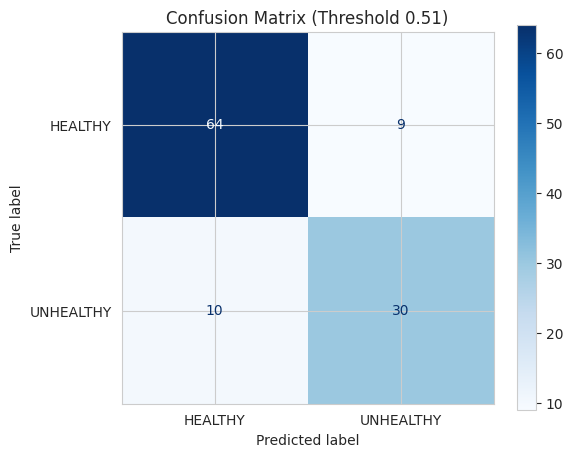


🔍 TOP 5 PREDICTORS (V3):
        Feature  Importance
5     wet_iqr_S   18.482452
0         wet_H   16.191623
2         wet_V   15.873819
4     wet_iqr_V   12.646379
9  rel_darkness   11.731383


In [28]:
print("\n" + "="*70)
print("🎯 EVALUATION & THRESHOLD TUNING")
print("="*70)

# Get Probabilities instead of hard predictions
y_probs = cb_model.predict_proba(X_test)[:, 1]

# Find Best Threshold (Maximizing F1)
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"💎 Optimal Threshold found: {best_threshold:.3f}")

# Apply Optimal Threshold
y_pred_tuned = (y_probs >= best_threshold).astype(int)
target_names = ['HEALTHY', 'UNHEALTHY']

# 1. Classification Report
print("\n--- Tuned Classification Report ---")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title(f"Confusion Matrix (Threshold {best_threshold:.2f})")
plt.show()

# 3. Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cb_model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print("\n🔍 TOP 5 PREDICTORS (V3):")
print(feat_imp.head(5))

In [26]:
def visualize_ml_analysis(df_test, X_train, y_train, model):
    """
    Visualizes ML results. 
    FIX: Strictly filters input columns to match X_train features only.
    """
    
    # Only select the columns that the model was trained on.
    # This ignores 'pred', 'gt', 'image', etc. that are in results_ml
    feature_cols = X_train.columns.tolist()
    
    # Check for missing columns (in case names changed)
    missing = [c for c in feature_cols if c not in df_test.columns]
    if missing:
        print(f"❌ Error: Input DataFrame is missing features: {missing}")
        return

    # Filter to only numeric features for prediction
    X_test_features = df_test[feature_cols]
    
    # Get Predictions
    y_pred = model.predict(X_test_features)
    
    # Create local results DF
    res_df = df_test.copy()
    res_df['pred'] = y_pred
    
    # Handle Ground Truth (might be 'target' or 'gt' depending on input)
    if 'target' in res_df.columns:
        res_df['gt'] = res_df['target']
    elif 'gt' not in res_df.columns:
        print("⚠️ Warning: No Ground Truth ('target' or 'gt') found.")
        res_df['gt'] = -1 # Dummy value
    
    label_map = {0: 'HEALTHY', 1: 'UNHEALTHY'}
    # Handle if pred/gt are already strings or integers
    if pd.api.types.is_numeric_dtype(res_df['pred']):
        res_df['pred_str'] = res_df['pred'].map(label_map)
    else:
        res_df['pred_str'] = res_df['pred'] # Already strings

    if pd.api.types.is_numeric_dtype(res_df['gt']):
        res_df['gt_str'] = res_df['gt'].map(label_map)
    else:
        res_df['gt_str'] = res_df['gt']

    # 2. Calculate Benchmarks from Train Data
    train_df = X_train.copy()
    train_df['target'] = y_train
    avg_healthy = train_df[train_df['target'] == 0].mean()
    avg_unhealthy = train_df[train_df['target'] == 1].mean()
    
    # Select Key Features for the Chart
    # Prioritize the V3 features if they exist
    potential_features = ['brown_index', 'diff_V', 'wet_iqr_V', 'rel_darkness']
    key_features = [f for f in potential_features if f in feature_cols]
    
    # Fallback if V3 features aren't found
    if not key_features:
        key_features = feature_cols[:4]

    # 3. Select Samples (3 per category)
    samples_list = []
    # Note: We filter based on the numeric 0/1 columns, or string match if needed
    is_pred_unhealthy = (res_df['pred'] == 1) | (res_df['pred_str'] == 'UNHEALTHY')
    is_gt_unhealthy = (res_df['gt'] == 1) | (res_df['gt_str'] == 'UNHEALTHY')
    
    categories = [
        ('False Positive (False Alarm)', is_pred_unhealthy & ~is_gt_unhealthy, 3),
        ('False Negative (Missed)',      ~is_pred_unhealthy & is_gt_unhealthy, 3),
        ('True Positive (Correct Dirty)', is_pred_unhealthy & is_gt_unhealthy, 3),
        ('True Negative (Correct Clean)', ~is_pred_unhealthy & ~is_gt_unhealthy, 3)
    ]
    
    for label, mask, count in categories:
        subset = res_df[mask]
        if len(subset) > 0:
            n_select = min(len(subset), count)
            selected = subset.sample(n_select, random_state=42).copy()
            selected['category'] = label
            samples_list.append(selected)

    if not samples_list:
        print("No samples found to visualize.")
        return

    viz_data = pd.concat(samples_list)
    n = len(viz_data)
    
    # 4. Plotting
    fig, axes = plt.subplots(n, 2, figsize=(16, 5 * n))
    if n == 1: axes = axes.reshape(1, -1)
    
    print(f"Displaying {n} ML-analyzed images...")

    for idx, (_, row) in enumerate(viz_data.iterrows()):
        # Handle different image column names
        img_name = row.get('image_name', row.get('image'))
        
        # --- LEFT: Image & Masks ---
        img_path = None
        for folder in [TEST_IMG_PATH, VAL_IMG_PATH, TRAIN_IMG_PATH]:
            if (folder / img_name).exists():
                img_path = folder / img_name
                break
        
        if img_path:
            img_bgr = cv2.imread(str(img_path))
            if img_bgr is not None:
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                ax_img = axes[idx, 0]
                ax_img.imshow(img_rgb)
                
                # Re-run inference for contours
                res_stick = dipstick_detection_model(img_bgr, verbose=False, conf=0.15)[0]
                if res_stick.masks:
                    for seg in res_stick.masks.xy:
                        ax_img.add_patch(patches.Polygon(seg, linewidth=2, edgecolor='cyan', facecolor='none'))
                
                res_oil = best_model_seg(img_bgr, verbose=False, conf=0.15)[0]
                if res_oil.masks:
                    for seg in res_oil.masks.xy:
                        ax_img.add_patch(patches.Polygon(seg, linewidth=2, edgecolor='orange', facecolor='orange', alpha=0.3))
                
                ax_img.axis('off')
                
                # Title
                is_error = row['pred'] != row['gt']
                color = '#D62728' if is_error else '#2CA02C' 
                ax_img.set_title(f"{row['category']}\nPred: {row['pred_str']} | GT: {row['gt_str']}", 
                                 color=color, fontweight='bold', fontsize=12)
        
        # --- RIGHT: Feature Chart ---
        ax_chart = axes[idx, 1]
        
        img_vals = [row[f] for f in key_features]
        healthy_vals = [avg_healthy[f] for f in key_features]
        dirty_vals = [avg_unhealthy[f] for f in key_features]
        
        y_pos = np.arange(len(key_features))
        height = 0.25
        
        # Bars
        ax_chart.barh(y_pos - height, healthy_vals, height, label='Avg Healthy', color='#2CA02C', alpha=0.5)
        ax_chart.barh(y_pos, dirty_vals, height, label='Avg Unhealthy', color='#D62728', alpha=0.5)
        
        # Smart Coloring for "THIS IMAGE"
        bar_colors = []
        for v, h_ref, d_ref in zip(img_vals, healthy_vals, dirty_vals):
            dist_h = abs(v - h_ref)
            dist_d = abs(v - d_ref)
            bar_colors.append('#D62728' if dist_d < dist_h else '#2CA02C')
            
        bars = ax_chart.barh(y_pos + height, img_vals, height, label='THIS IMAGE', color=bar_colors, edgecolor='black', linewidth=1.5)
        
        ax_chart.set_yticks(y_pos)
        ax_chart.set_yticklabels(key_features, fontsize=11, fontweight='bold')
        ax_chart.invert_yaxis()
        ax_chart.set_xlabel('Feature Value')
        ax_chart.set_title("Decision Factors", fontsize=12)
        
        if idx == 0: ax_chart.legend()
        ax_chart.grid(axis='x', linestyle='--', alpha=0.5)
        
        for i, bar in enumerate(bars):
             ax_chart.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                          f" {img_vals[i]:.2f}", va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(OUT_PATH / 'ml_analysis_v3_balanced.png')
    plt.show()
    print(f"✅ Visualization saved to {OUT_PATH / 'ml_analysis_v3_balanced.png'}")

✅ 'results_ml' DataFrame created successfully.
Displaying 12 ML-analyzed images...


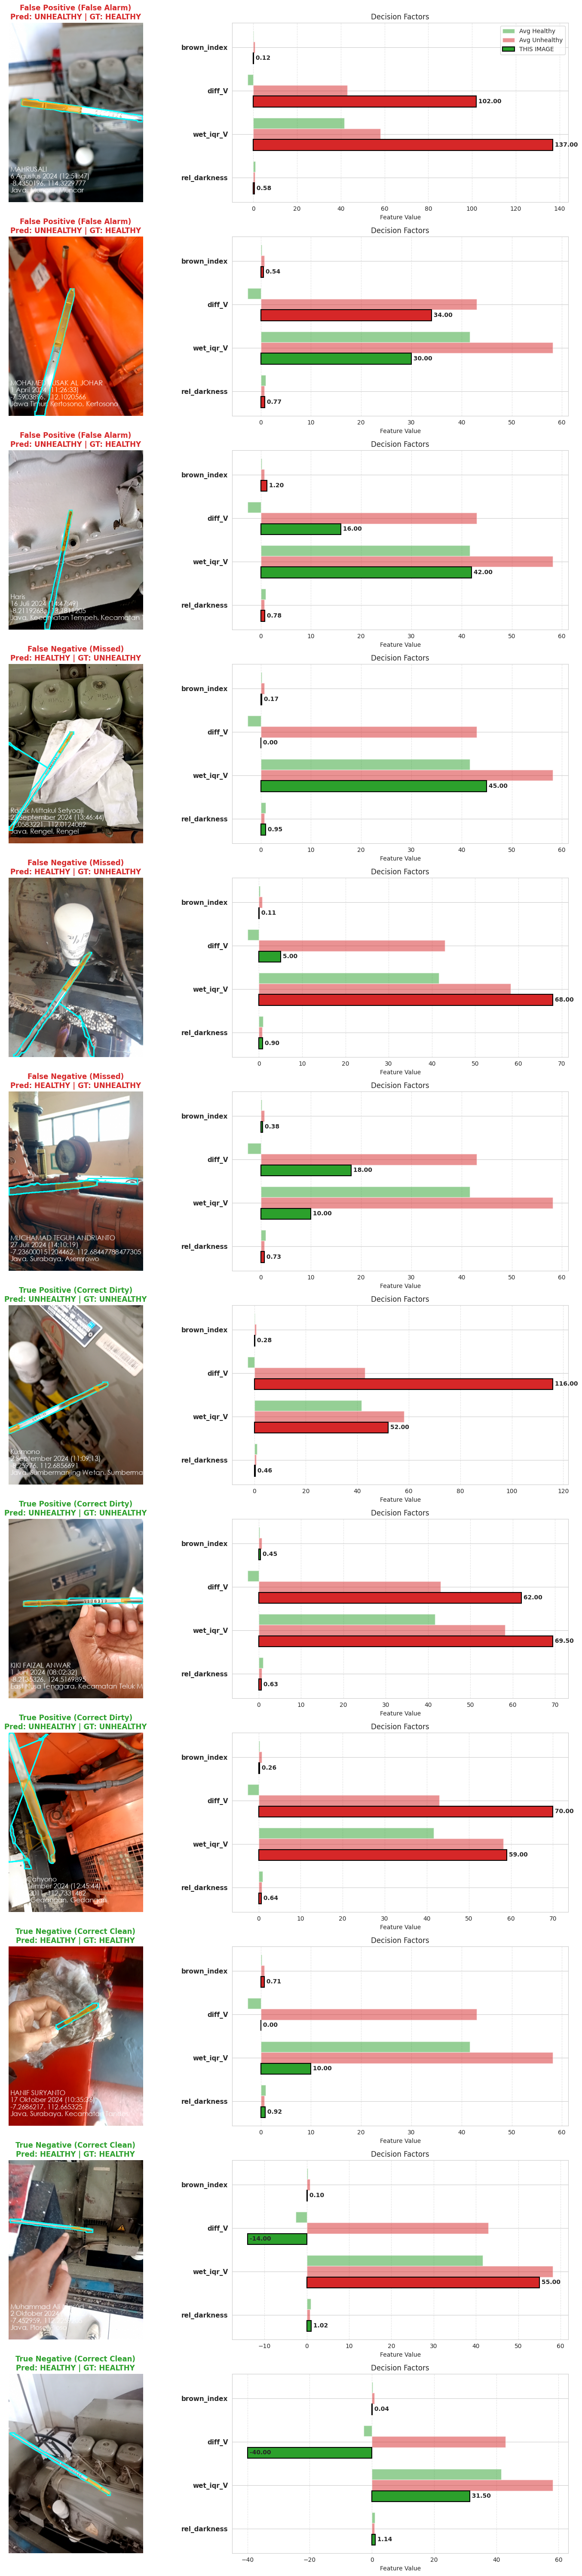

✅ Visualization saved to /kaggle/working/ml_analysis_v3_balanced.png


In [29]:
# 1. CREATE THE RESULTS DATAFRAME
results_ml = df_test.copy()

# Get predictions and probabilities from your trained model
results_ml['pred_prob'] = cb_model.predict_proba(X_test)[:, 1]
results_ml['pred'] = cb_model.predict(X_test)

# Map numeric labels to text for readability
health_map = {0: 'HEALTHY', 1: 'UNHEALTHY'}
results_ml['pred_str'] = results_ml['pred'].map(health_map)
results_ml['gt_str'] = results_ml['target'].map(health_map)

# Ensure 'diff' column exists for the visualizer (Mapping from diff_V)
if 'diff_V' in results_ml.columns:
    results_ml['diff'] = results_ml['diff_V']
else:
    # Fallback calculation if column is missing
    results_ml['diff'] = results_ml['dry_V'] - results_ml['wet_V']

print("✅ 'results_ml' DataFrame created successfully.")

# 2. RUN THE VISUALIZER
visualize_ml_analysis(results_ml, X_train, y_train, cb_model)